<a href="https://colab.research.google.com/github/VMBoehm/SDSS_PAE/blob/main/LSTM_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting the Density Estimator

In [1]:
## todo add forked repo as origin or upstream
## check paths
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#! pip install --user -e /global/u2/v/vboehm/codes/SIG_GIS/

In [3]:
import sys

In [4]:
sys.path.append('/global/u2/v/vboehm/codes/SIG_GIS/')

In [5]:
from sig_gis import *

In [6]:
from sig_gis.GIS import *

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [8]:
root_models     = '/global/cscratch1/sd/vboehm/Models/SDSS_AE/'

root_encoded    = '/global/cscratch1/sd/vboehm/Datasets/encoded/sdss/'
root_decoded    = '/global/cscratch1/sd/vboehm/Datasets/decoded/sdss/'
root_data       = '/global/cscratch1/sd/vboehm/Datasets'
root_model_data = '/global/cscratch1/sd/vboehm/Datasets/sdss/by_model/'
root_outliers   = '/global/cscratch1/sd/vboehm/SDSSOutlier'



label           = 'galaxies_quasars_bins1000_wl3388-8318'
label_          = label+'_minz005_maxz036_minSN50'
label_2         = label+'_minz01_maxz036_minSN50'+'_8_fully_connected_mean_div'

seed            = 8720

latent_dim      = 8
network_type    = 'fully_connected'


wlmin, wlmax    = (3388,8318)
fixed_num_bins  = 1000
wl_range      = (np.log10(wlmin),np.log10(wlmax))
# new binning 
new_wl        = np.logspace(wl_range[0],wl_range[1],fixed_num_bins+1)

alpha         = (0.8,0.8)

maxiter       = 500

label_3       = label_2+"alpha%d_maxiter%d"%(int(alpha[0]*10),maxiter)



encoded_train, encoded_valid, encoded_test = np.load(os.path.join(root_encoded,'encoded_%s.npy'%label_2), allow_pickle=True)
decoded_train, decoded_valid, decoded_test, mean = np.load(os.path.join(root_decoded,'decoded_%s.npy'%label_2), allow_pickle=True)



seed = 8365

In [9]:
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    device = torch.device('cuda')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device = torch.device('cpu')

In [10]:
encoded_train = torch.tensor(encoded_train).to(device)
encoded_valid = torch.tensor(encoded_valid).to(device)
encoded_test = torch.tensor(encoded_test).to(device)

In [11]:
print(os.path.join(root_models,'GIS_%s'%label_3))

/global/cscratch1/sd/vboehm/Models/SDSS_AE/GIS_galaxies_quasars_bins1000_wl3388-8318_minz01_maxz036_minSN50_8_fully_connected_mean_divalpha8_maxiter500


In [12]:
try:
    model =  torch.load(os.path.join(root_models,'GIS_%s'%label_3))
except:
    print('model not found')

In [13]:
valid_data = np.load(os.path.join(root_model_data,'valid_%s.npy.npz'%label_2))

In [14]:
test_data = np.load(os.path.join(root_model_data,'test_%s.npy.npz'%label_2))

In [15]:
logps_valid   = model.evaluate_density(encoded_valid).cpu()
indices_valid = np.argsort(logps_valid)

logps_test   = model.evaluate_density(encoded_test).cpu()
indices_test = np.argsort(logps_test)

logps_train   = model.evaluate_density(encoded_train).cpu()
indices_train = np.argsort(logps_train)

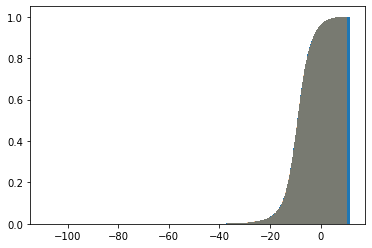

In [23]:
_ = plt.hist(logps_valid.numpy(),bins=1000,density=True,cumulative=True)
_ = plt.hist(logps_test.numpy(),bins=1000,alpha=0.4,density=True,cumulative=True)

Text(0.5, 0, 'logps')

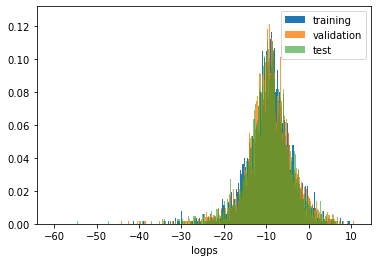

In [24]:
_ = plt.hist(logps_train.numpy()[0:10000],bins=1000,density=True,cumulative=False, label='training')
_ = plt.hist(logps_valid.numpy()[0:10000],bins=1000,alpha=0.8,density=True,cumulative=False, label='validation')
_ = plt.hist(logps_test.numpy()[0:10000],bins=1000,alpha=0.6,density=True,cumulative=False, label='test')

plt.legend()
plt.xlabel('logps')

In [25]:
np.savez(os.path.join(root_outliers,'valid_test_train_logps.npy'),logps_valid,logps_test, logps_train)

In [26]:
valid_data['arr_3'][0],valid_data['arr_4'][0],valid_data['arr_5'][0],valid_data['arr_6'][0],valid_data['arr_8'][0],valid_data['arr_9'][0],valid_data['arr_10'][0]

(0.23352191, 119.65175, 13.15451, b'2.0', b'55568.0', b'4506.0', b'835.0')

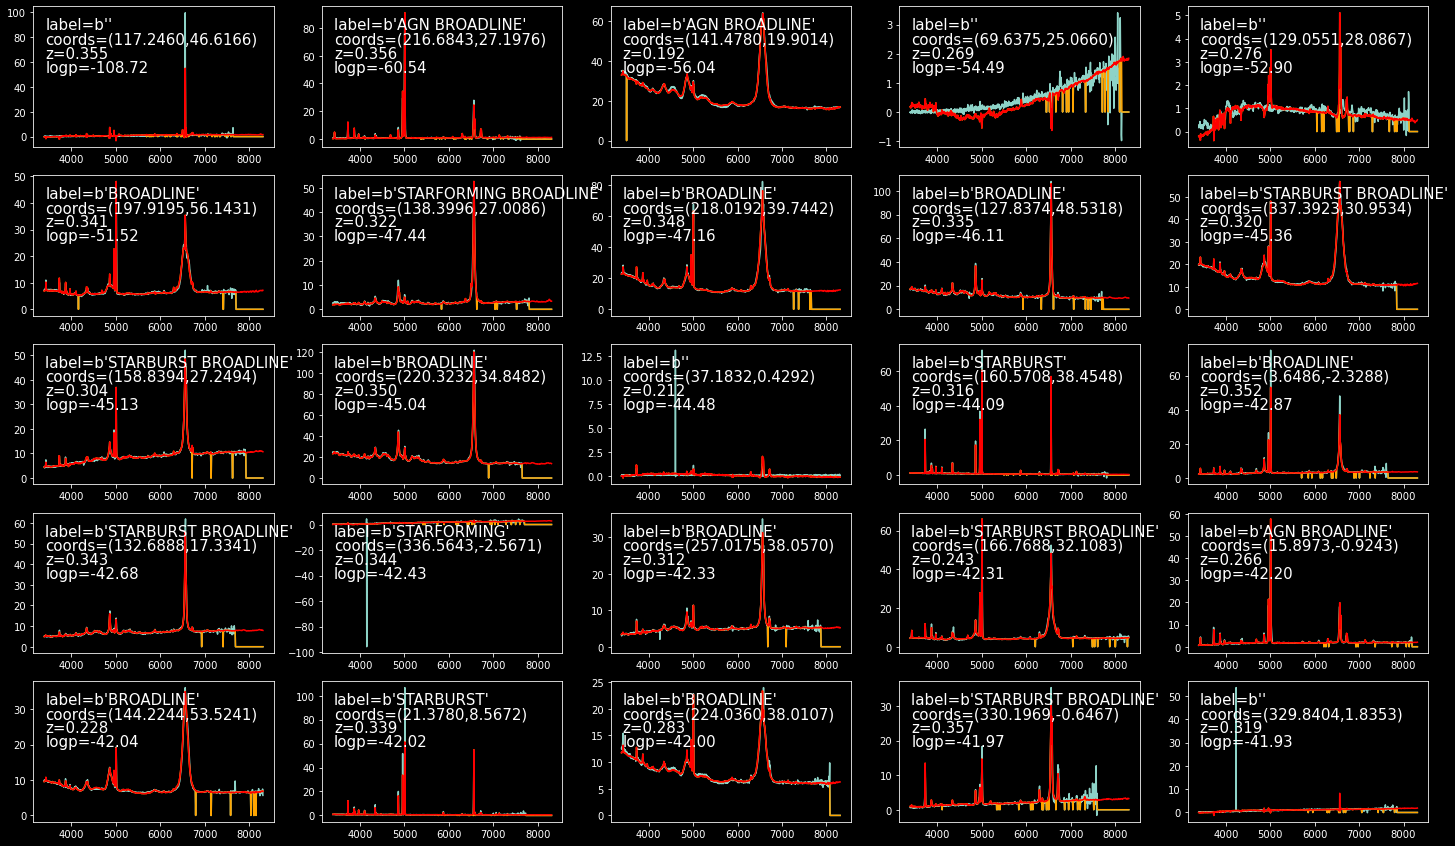

In [27]:
style_list=['dark_background']
# Plot a demonstration figure for every available style sheet.
for style_label in style_list:
    with plt.rc_context({"figure.max_open_warning": len(style_list)}):
        with plt.style.context(style_label):
            fig, ax = plt.subplots(5,5, figsize=(25,15))
            ax = ax.flatten()
            for nn, ii in enumerate(indices_valid[0:25]):
                ax[nn].plot(new_wl[:-1], (np.squeeze(valid_data['arr_0'])[ii])*np.squeeze(valid_data['arr_1'])[ii], )
                ax[nn].plot(new_wl[:-1], (np.squeeze(decoded_valid)[ii])*np.squeeze(valid_data['arr_1'])[ii], color='orange')
                ax[nn].plot(new_wl[:-1], (np.squeeze(decoded_valid)[ii]), color='red')
                ax[nn].text(0.05, 0.92, r'label=%s'%valid_data['arr_7'][ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                ax[nn].text(0.05, 0.82, r'coords=(%.4f,%.4f)'%(valid_data['arr_4'][ii],valid_data['arr_5'][ii]), fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                ax[nn].text(0.05, 0.72, r'z=%.3f'%valid_data['arr_3'][ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                ax[nn].text(0.05, 0.62, r'logp=%.2f'%logps_valid[ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)

plt.show()

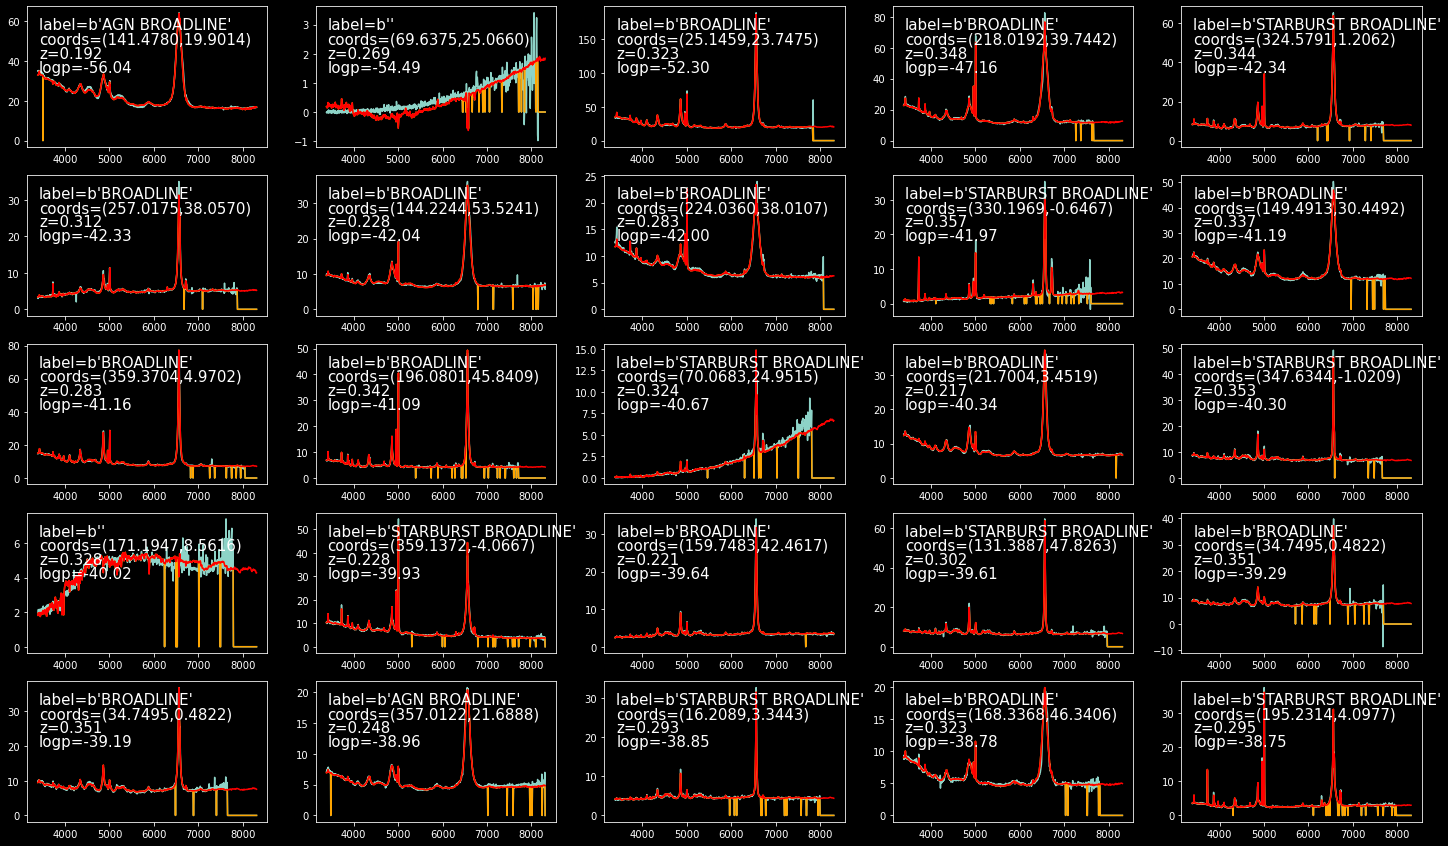

In [28]:
style_list=['dark_background']
# Plot a demonstration figure for every available style sheet.
for style_label in style_list:
    with plt.rc_context({"figure.max_open_warning": len(style_list)}):
        with plt.style.context(style_label):
            
            fig, ax = plt.subplots(5,5, figsize=(25,15))
            ax = ax.flatten()
            for nn, ii in enumerate(indices_test[0:25]):
                ax[nn].plot(new_wl[:-1], (np.squeeze(test_data['arr_0'])[ii])*np.squeeze(test_data['arr_1'])[ii], )
                ax[nn].plot(new_wl[:-1], (np.squeeze(decoded_test)[ii])*np.squeeze(test_data['arr_1'])[ii], color='orange')
                ax[nn].plot(new_wl[:-1], (np.squeeze(decoded_test)[ii]), color='red')
                ax[nn].text(0.05, 0.92, r'label=%s'%test_data['arr_7'][ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                ax[nn].text(0.05, 0.82, r'coords=(%.4f,%.4f)'%(test_data['arr_4'][ii],test_data['arr_5'][ii]), fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                ax[nn].text(0.05, 0.72, r'z=%.3f'%test_data['arr_3'][ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                ax[nn].text(0.05, 0.62, r'logp=%.2f'%logps_test[ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)

plt.show()

In [29]:
ood_valid_fibers = valid_data['arr_10'][indices_valid]
ood_valid_plate = valid_data['arr_9'][indices_valid]
ood_valid_MJD = valid_data['arr_8'][indices_valid]
ood_valid_coord1 = valid_data['arr_4'][indices_valid]
ood_valid_coord2 = valid_data['arr_5'][indices_valid]
ood_valid_params = valid_data['arr_3'][indices_valid]

In [30]:
np.savez(os.path.join(root_outliers,'MJD_plate_fiber_top1000outliers_valid.npy'), ood_valid_MJD[:1000], ood_valid_plate[:1000], ood_valid_fibers[:1000])

In [31]:
ood_test_fibers = test_data['arr_10'][indices_test]
ood_test_plate = test_data['arr_9'][indices_test]
ood_test_MJD = test_data['arr_8'][indices_test]
ood_test_coord1 = test_data['arr_4'][indices_test]
ood_test_coord2 = test_data['arr_5'][indices_test]
ood_test_params = test_data['arr_3'][indices_test]

In [32]:
np.savez(os.path.join(root_outliers,'MJD_plate_fiber_top1000outliers_test.npy'), ood_test_MJD[:1000], ood_test_plate[:1000], ood_test_fibers[:1000])

In [33]:
with open('ood_valid_lowest_1000.txt', 'w') as f:
    for ii in range(1000):
        f.write('%d,%d,%d'%(int(float(ood_valid_plate[ii])), int(float(ood_valid_MJD[ii])), int(float(ood_valid_fibers[ii]))+1))
        f.write('\n')
f.close()

In [34]:
with open('ood_test_lowest_1000.txt', 'w') as f:
    for ii in range(1000):
        f.write('%d,%d,%d'%(int(float(ood_test_plate[ii])), int(float(ood_test_MJD[ii])), int(float(ood_test_fibers[ii]))+1))
        f.write('\n')
f.close()

In [35]:
for ii in range(0,10):
    print('%d,%d,%d'%(int(float(ood_valid_plate[ii])), int(float(ood_valid_MJD[ii])), int(float(ood_valid_fibers[ii]))))
for ii in range(0,10):
    print(ood_valid_coord1[ii], ood_valid_coord2[ii], ood_valid_params[ii])

3673,55152,804
6018,56067,457
9561,57809,211
7262,56682,357
9611,58136,612
8215,58197,17
9608,58137,127
10749,58485,472
7318,56738,39
7711,57667,915
117.24597 46.616642 0.35549036
216.68427 27.197598 0.3557449
141.47798 19.901423 0.19209492
69.63752 25.065952 0.26896384
129.05515 28.086693 0.27580413
197.91946 56.143074 0.34116033
138.39955 27.008595 0.32229483
218.01917 39.74418 0.34830287
127.83743 48.531788 0.33467957
337.39227 30.953365 0.31951326


In [36]:
for ii in range(10):
    print('%d,%d,%d'%(int(float(ood_test_plate[ii])), int(float(ood_test_MJD[ii])), int(float(ood_test_fibers[ii]))+1))
for ii in range(10):
    print(ood_test_coord1[ii], ood_test_coord2[ii], ood_test_params[ii])

9561,57809,212
7262,56682,358
7687,57007,980
10749,58485,473
9163,58043,152
10761,58283,44
7286,57096,113
10748,58224,819
4199,55481,482
11379,58438,32
141.47798 19.901423 0.19209492
69.63752 25.065952 0.26896384
25.145897 23.747536 0.32338157
218.01917 39.74418 0.34830287
324.57907 1.206223 0.34417415
257.01755 38.05701 0.31153175
144.22437 53.524124 0.2275806
224.03596 38.010715 0.2833227
330.19687 -0.646713 0.35659268
149.49135 30.449234 0.33698002


In [37]:
import pandas as pd

In [39]:
df = pd.read_csv(os.path.join('/global/u2/v/vboehm/codes/SDSS_PAE/notebooks/outlier_data/','optical_search_1000validoutlier.csv'))

In [40]:
df

,#plate,mjd,fiberid,run2d,specobj_id,ra,dec,sn_median_r,z,zerr,zwarning,class,subclass
0,3586,55181,297,'v5_13_0','4037558791600099328','00:31:48.56','-00:41:14.10',13.81,0.354044,0.000037,0,'GALAXY',''
1,3588,55184,569,'v5_13_0','4039885358254804992','00:37:11.00','+00:21:27.83',33.30,0.235094,0.000023,0,'QSO','BROADLINE'
2,3588,55184,574,'v5_13_0','4039886732644339712','00:36:54.33','+00:25:50.37',13.75,0.338653,0.000033,0,'GALAXY',''
3,3589,55186,428,'v5_13_0','4040972500410322944','00:40:32.11','-00:13:50.84',19.17,0.241805,0.000033,0,'QSO','BROADLINE'
4,3590,55201,606,'v5_13_0','4042147328836259840','00:45:20.10','+00:33:23.46',12.06,0.272236,0.000032,0,'QSO','STARBURST BROADLINE'
...,...,...,...,...,...,...,...,...,...,...,...,...,...
943,11633,58463,12,'v5_13_0','-5349147016887513088','22:41:40.32','+29:34:44.00',3.81,0.347861,0.000098,0,'GALAXY',''
944,11634,58484,809,'v5_13_0','-5347802038936514560','22:41:54.44','+33:23:18.87',20.35,0.165950,0.000038,0,'QSO','BROADLINE'
945,11653,58526,102,'v5_13_0','-5326604278682071040','17:09:10.42','+30:27:46.74',13.19,0.345338,0.000023,0,'QSO','BROADLINE'
946,11654,58543,62,'v5_13_0','-5325489373606293504','17:21:18.95','+30:30:00.18',3.18,0.353300,0.000038,0,'QSO','STARBURST'


In [41]:
array= np.vstack([ood_valid_plate.astype(float).astype(int)[:1000], ood_valid_MJD.astype(float).astype(int)[:1000], ood_valid_fibers.astype(float).astype(int)[:1000]+1, ood_valid_params[:1000], ood_valid_coord1[:1000], ood_valid_coord2[:1000]])

In [42]:
df_2 = pd.DataFrame(array.T,columns=['#plate','mjd','fiberid','z','ra', 'dec'])

In [43]:
df_2

,#plate,mjd,fiberid,z,ra,dec
0,3673.0,55152.0,805.0,0.355490,117.245972,46.616642
1,6018.0,56067.0,458.0,0.355745,216.684265,27.197598
2,9561.0,57809.0,212.0,0.192095,141.477982,19.901423
3,7262.0,56682.0,358.0,0.268964,69.637520,25.065952
4,9611.0,58136.0,613.0,0.275804,129.055145,28.086693
...,...,...,...,...,...,...
995,4544.0,55855.0,196.0,0.343117,13.392652,9.126729
996,5767.0,56245.0,287.0,0.346080,141.482437,17.933165
997,7057.0,56593.0,312.0,0.355065,40.673553,-8.147307
998,5981.0,56340.0,265.0,0.277976,188.433990,27.203560


In [44]:
df_overlap=df.merge(df_2,how='inner',on=['#plate','mjd','fiberid'])

In [45]:
df_overlap

,#plate,mjd,fiberid,run2d,specobj_id,ra_x,dec_x,sn_median_r,z_x,zerr,zwarning,class,subclass,z_y,ra_y,dec_y
0,3586,55181,297,'v5_13_0','4037558791600099328','00:31:48.56','-00:41:14.10',13.81,0.354044,0.000037,0,'GALAXY','',0.354044,7.952337,-0.687249
1,3588,55184,569,'v5_13_0','4039885358254804992','00:37:11.00','+00:21:27.83',33.30,0.235094,0.000023,0,'QSO','BROADLINE',0.235094,9.295844,0.357731
2,3588,55184,574,'v5_13_0','4039886732644339712','00:36:54.33','+00:25:50.37',13.75,0.338653,0.000033,0,'GALAXY','',0.338653,9.226391,0.430659
3,3589,55186,428,'v5_13_0','4040972500410322944','00:40:32.11','-00:13:50.84',19.17,0.241805,0.000033,0,'QSO','BROADLINE',0.241805,10.133773,-0.230790
4,3590,55201,606,'v5_13_0','4042147328836259840','00:45:20.10','+00:33:23.46',12.06,0.272236,0.000032,0,'QSO','STARBURST BROADLINE',0.272236,11.333730,0.556517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
943,11633,58463,12,'v5_13_0','-5349147016887513088','22:41:40.32','+29:34:44.00',3.81,0.347861,0.000098,0,'GALAXY','',0.347861,340.417999,29.578890
944,11634,58484,809,'v5_13_0','-5347802038936514560','22:41:54.44','+33:23:18.87',20.35,0.165950,0.000038,0,'QSO','BROADLINE',0.165950,340.476837,33.388573
945,11653,58526,102,'v5_13_0','-5326604278682071040','17:09:10.42','+30:27:46.74',13.19,0.345338,0.000023,0,'QSO','BROADLINE',0.345338,257.293427,30.462984
946,11654,58543,62,'v5_13_0','-5325489373606293504','17:21:18.95','+30:30:00.18',3.18,0.353300,0.000038,0,'QSO','STARBURST',0.353300,260.328949,30.500050


In [46]:
df_3 = df_2.merge(df,indicator = True, how='left',on=['#plate','mjd','fiberid']).loc[lambda x : x['_merge']!='both']

In [47]:
df_3= df_3.drop(columns=['run2d','specobj_id','ra_y','dec_y','sn_median_r','z_y','zerr', 'zwarning', 'class', 'subclass', '_merge'])

In [48]:
df_3 = df_3.rename(columns={'z_x':'z', 'ra_x':'ra', 'dec_x':'dec'})

In [49]:
df_3.to_csv(os.path.join('./outlier_data','unmatched_valid_outliers.csv'))

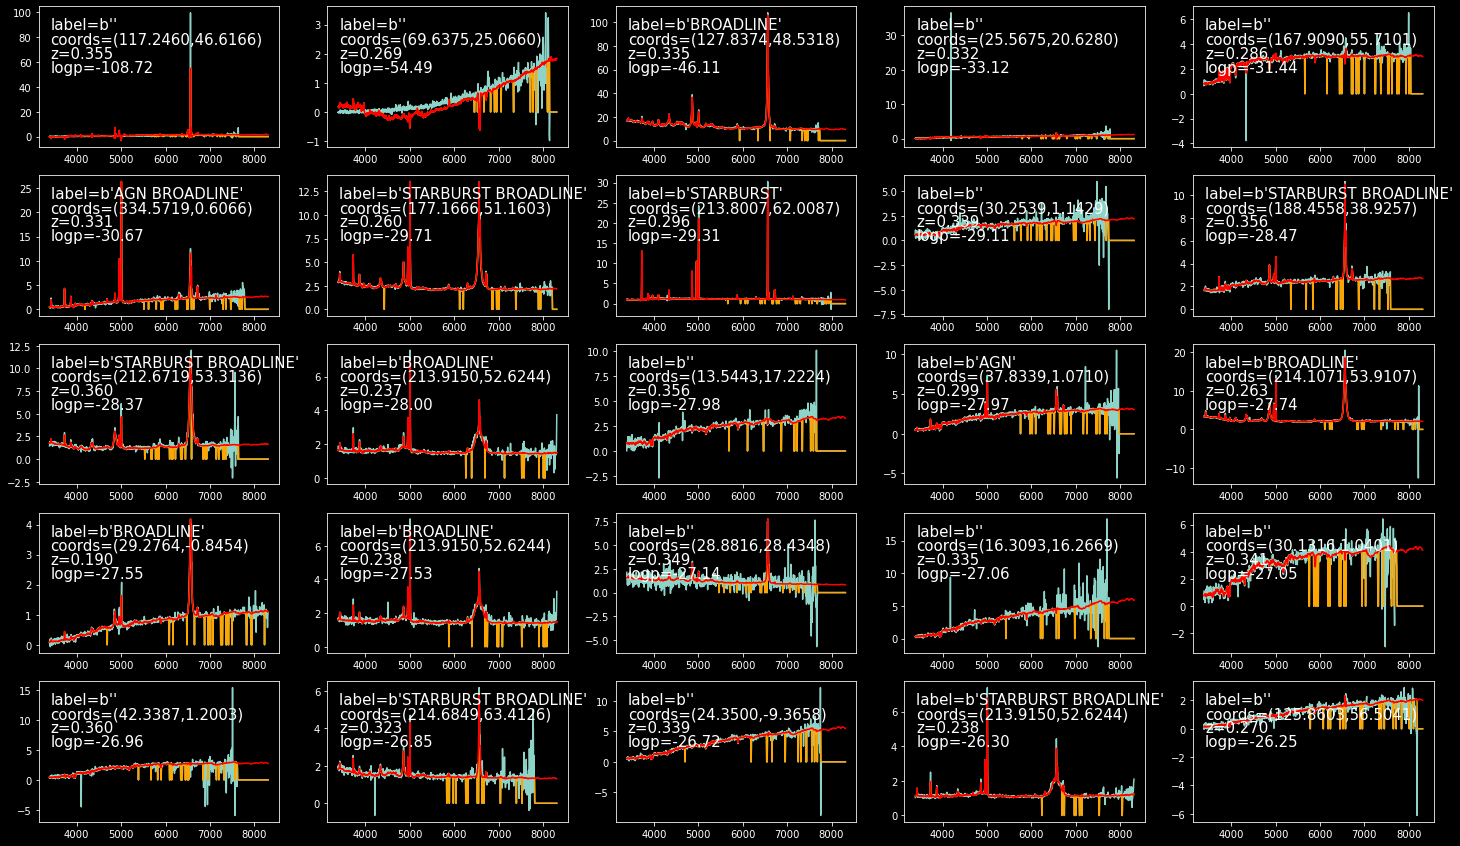

In [50]:
##change to show correct spectra

style_list=['dark_background']
# Plot a demonstration figure for every available style sheet.
for style_label in style_list:
    with plt.rc_context({"figure.max_open_warning": len(style_list)}):
        with plt.style.context(style_label):
            
            fig, ax = plt.subplots(5,5, figsize=(25,15))
            ax = ax.flatten()
            for nn, ii in enumerate(df_3.index[0:25]):
                print
                ax[nn].plot(new_wl[:-1], (np.squeeze(valid_data['arr_0'])[indices_valid][ii])*np.squeeze(valid_data['arr_1'][indices_valid])[ii], )
                ax[nn].plot(new_wl[:-1], (np.squeeze(decoded_valid)[indices_valid][ii])*np.squeeze(valid_data['arr_1'][indices_valid])[ii], color='orange')
                ax[nn].plot(new_wl[:-1], (np.squeeze(decoded_valid[indices_valid])[ii]), color='red')
                ax[nn].text(0.05, 0.92, r'label=%s'%valid_data['arr_7'][indices_valid][ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                ax[nn].text(0.05, 0.82, r'coords=(%.4f,%.4f)'%(valid_data['arr_4'][indices_valid][ii],valid_data['arr_5'][indices_valid][ii]), fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                ax[nn].text(0.05, 0.72, r'z=%.3f'%valid_data['arr_3'][indices_valid][ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                ax[nn].text(0.05, 0.62, r'logp=%.2f'%logps_valid[indices_valid][ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)

plt.show()

In [51]:
### derivative 

In [26]:
"""
def closure():
        optimizer.zero_grad()
        output = model(input)
        loss = loss_fn(output, target)
        loss.backward()
        return loss
"""

In [20]:

 # the desired network response

num_steps = 20  # how many optim steps to take
updates   = []
logps     = []
for nn in range(1):
    print(nn)
    model.requires_grad_(False)
    x = torch.nn.Parameter(encoded_valid[indices_valid][nn], requires_grad=True)
    optim = torch.optim.LBFGS([x],lr=1e-4, history_size=3)
    for _ in range(num_steps):
        updates.append(x.cpu().detach().numpy())
        def closure():
            optim.zero_grad()
            logp = -model.evaluate_density(x)
            logp.backward()
            return logp
        logps.append(closure().cpu().detach().numpy())
        
        optim.step(closure)
        
    
    

0


In [ ]:
logps=np.asarray(logps)
print(logps.shape), 20*25

In [ ]:
logps

In [15]:
updates = []
logps   = []
for nn in range(25):
    print(nn)
    encoded_valid_sorted = encoded_valid[indices_valid][nn]
    encoded_valid_sorted = encoded_valid_sorted.clone().detach().requires_grad_(True)
    current_pos          = encoded_valid_sorted
    external_grad = torch.tensor(np.ones((1)))
    logp_ = model.evaluate_density(current_pos)
    logps.append(logp_.cpu().detach().numpy())
    updates.append(current_pos.cpu().detach().numpy())
    for ii in range(10):

        logp_.backward(gradient=external_grad)

        gradients = encoded_valid_sorted.grad

        cont = True
        step      = np.ones((8), dtype=np.float32)*5
        step      = torch.tensor(step).to(device)
        while cont:

            update      = current_pos+gradients*step
            logp_update = model.evaluate_density(update)

            if logp_update.cpu()<logp_.cpu():
                step*=0.5
            #    print('repeat')
            else:
            #if len(ind) ==0:
                cont=False
            #else:
            #    step[ind]=step[ind]*0.5

        current_pos = update
        logp_       = model.evaluate_density(current_pos)
        logps.append(logp_.cpu().detach().numpy())
        updates.append(current_pos.cpu().detach().numpy())

0


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-7674e01a2337>", line 24, in <module>
    logp_update = model.evaluate_density(update)
  File "/global/u2/v/vboehm/codes/SIG_GIS/sig_gis/SINF.py", line 130, in evaluate_density
    data, logj = self.forward(data, start=start, end=end, param=param)
  File "/global/u2/v/vboehm/codes/SIG_GIS/sig_gis/SINF.py", line 39, in forward
    data, log_j = self.layer[i](data, param=param)
  File "/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/module.py", line 889, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/global/u2/v/vboehm/codes/SIG_GIS/sig_gis/SINF.py", line 632, in forward
    return self.transform(data, mode='forward', param=param)
  File "/global/u2/v/vboehm/codes/SIG_GIS/sig_gis/SI

TypeError: object of type 'NoneType' has no len()

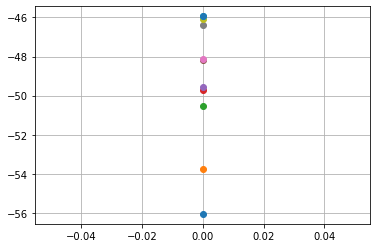

In [47]:
np.savez('derivative_top25_valid_adam.npy', np.asarray(-logps).reshape(25,20,1),np.asarray(updates).reshape(25,20,8))

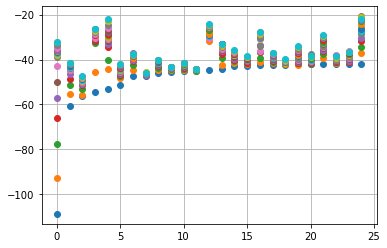

In [48]:
logps = np.asarray(logps).reshape(25,20,1)
for ii in range(logps.shape[1]):
    plt.plot(-logps[:,ii,:], ls='', marker='o')
plt.grid()